## BiParabolic model

The bi-parabolic model is designed to determine a piecewise parabolic fit to the average traffic flow and occupancy for a city, corresponding to the MFD. 


In [ ]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats


# plot layout, darkgrid
sns.set(style="darkgrid")

In [2]:
# read the preprocessed data, the calculated averages for the 29 relevant cities
data_avg = pd.read_csv('C:/DTU/Speciale/Kode/Speciale/data/processed/averages.csv')

# get all the cities in the data_avg
cities = data_avg['city'].unique()

# normalize by city
data_avg['norm_flow'] = data_avg.groupby('city')['avg_flow'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data_avg['norm_occ'] = data_avg.groupby('city')['avg_occupancy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Defining the BiParabolic model

In [5]:
# A class for the FocalMSELoss
class FocalMSELoss(nn.Module):
        def __init__(self, gamma=2.0):
            super(FocalMSELoss, self).__init__()
            self.gamma = gamma  # Gamma controls the strength of the focal effect

        def forward(self, predictions, targets):
            # Compute the residuals (errors)
            residuals = torch.abs(targets - predictions)
            
            # Scale the loss with (1 - residual)^gamma (the focal component)
            focal_weight = (1.0 - residuals / residuals.max()).pow(self.gamma)

            # Apply the weights to the MSE loss
            loss = focal_weight * nn.functional.mse_loss(predictions, targets, reduction='none')
            return loss.mean()  # Return the mean loss

In [ ]:
class BiParabolicNN(nn.Module):
    def __init__(self, occupancy, flow, alpha=1.0, beta=1.0):
        super(BiParabolicNN, self).__init__()
        self.occupancy = occupancy
        self.flow = flow
        self.alpha = alpha
        self.beta = beta

        # Logits for softmax, controlling the placement of the cd
        self.logits = nn.Parameter(torch.zeros(len(occupancy), device=occupancy.device, requires_grad=True))

        # Parabola coefficients for the second parabola (ensure it's negative)
        self.parabola2_a_logit = nn.Parameter(torch.tensor([0.0], device=occupancy.device))

        # New parameter for the flow value at cd
        self.flow_at_cd = nn.Parameter(torch.tensor([0.5], device=occupancy.device))  # Initialize to 0.5, will be optimized


    def forward(self):
        # Get weights from logits using softmax
        weights = torch.softmax(self.logits, dim=0)

        # Compute the critical density (cd) and corresponding flow (flow_cd)
        cd = torch.sum(weights * self.occupancy)
        flow_cd = torch.sum(weights * self.flow)

        # Use the new parameter for the flow value at cd
        flow_at_cd = self.flow_at_cd.abs()  # Ensure it's positive

        # First parabolic fit: downward-opening parabola passing through (0, 0) and (cd, flow_at_cd)
        parabola1_a = -flow_at_cd / (cd ** 2)
        fit1 = parabola1_a * (self.occupancy - cd) ** 2 + flow_at_cd
        fit1 = fit1 * (self.occupancy <= cd)

        # Second parabolic fit: from (cd, flow_at_cd) to the second intersection with x-axis
        parabola2_a = -torch.exp(self.parabola2_a_logit)  # Ensure it's negative
        fit2 = parabola2_a * ((self.occupancy - cd) ** 2) + flow_at_cd
        fit2 = fit2 * (self.occupancy > cd)

        # Full bi-parabolic fit
        fit = fit1 + fit2

        return fit, cd, flow_cd, flow_at_cd, fit1, fit2

    def compute_loss(self, fit, penalty, fit1, fit2, weighted_loss='no', gamma=2.0):
        # Calculate cd by softmax
        cd = torch.sum(torch.softmax(self.logits, dim=0) * self.occupancy)
        mse_fit1, mse_fit2 = 0, 0

        # Mask for data points before and after cd
        mask_before_cd = self.occupancy <= cd
        mask_after_cd = self.occupancy > cd
        
        if weighted_loss == 'no':
            mse_fit1 = nn.MSELoss()(fit1[mask_before_cd], self.flow[mask_before_cd])
            mse_fit2 = nn.MSELoss()(fit2[mask_after_cd], self.flow[mask_after_cd])
        elif weighted_loss == 'inv_freq':
            num_left = mask_before_cd.sum().item()
            num_right = mask_after_cd.sum().item()

            weight_left = num_right / (num_left + num_right)
            weight_right = num_left / (num_left + num_right)

            mse_fit1 = weight_left * nn.MSELoss()(fit1[mask_before_cd], self.flow[mask_before_cd])
            mse_fit2 = weight_right * nn.MSELoss()(fit2[mask_after_cd], self.flow[mask_after_cd])

        elif weighted_loss == 'focal':
            focal_loss = FocalMSELoss(gamma=gamma)
            mse_fit1 = focal_loss(fit1[mask_before_cd], self.flow[mask_before_cd])
            mse_fit2 = focal_loss(fit2[mask_after_cd], self.flow[mask_after_cd])

        # Total loss is a combination of MSE and the penalty for cd constraints
        loss = self.beta * (mse_fit1 + mse_fit2) + self.alpha * penalty
        return loss
    
    def calculate_prediction_intervals(self, quantile=0.95):
        with torch.no_grad():
            fit, cd, flow_cd, flow_at_cd, fit1, fit2 = self.forward()
            
            residuals = self.flow - fit
            std_dev = torch.std(residuals)
            
            # Calculate the z-score for the given quantile
            z_score = stats.norm.ppf((1 + quantile) / 2)
            
            lower_bound = fit - z_score * std_dev
            upper_bound = fit + z_score * std_dev
            
        return lower_bound, upper_bound


# Example of how to train the model
def train_model(occupancy, flow, alpha=1.0, beta=1.0, num_epochs=1000, learning_rate=0.01, device='cpu', weighted_loss='no', gamma=2.0):
    model = BiParabolicNN(occupancy.to(device), flow.to(device), alpha=alpha, beta=beta).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    
    for epoch in range(num_epochs):
        # Forward pass
        fit, cd, flow_cd, flow_at_cd, fit1, fit2 = model()  # Now unpacking all six returned values

        # Compute the penalty for regularization (encouraging cd to be near the top of flow)
        penalty = torch.sum((model.flow - flow_cd).clamp(min=0)).to(device)

        # Compute the total loss
        loss = model.compute_loss(fit, penalty, fit1, fit2, weighted_loss=weighted_loss, gamma=gamma)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss value
        losses.append(loss.item())

        # Output for every 100 epochs
        if (epoch + 1) % 100 == 0:
            mse_fit1 = nn.MSELoss()(fit1, model.flow * (model.occupancy <= cd)).item()
            mse_fit2 = nn.MSELoss()(fit2, model.flow * (model.occupancy > cd)).item()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, MSE fit1: {mse_fit1:.4f}, MSE fit2: {mse_fit2:.4f}, Flow at cd: {flow_cd.item():.4f}, Flow at junction: {flow_at_cd.item():.4f}')

    return model, losses



### Setting up the plots

To better compare the fit across cities, it is possible to plot the cities specified by the list 'cities' in plot_city_results_for_batch() together in subplots.

In [ ]:
def plot_results_on_subplot(ax_fit, ax_loss, model, occupancy, flow, losses, epoch_interval=100, title='Traffic Flow vs Occupancy - Bi-Parabolic Fit', quantile=0.95):
    model.eval()

    with torch.no_grad():
        fit, cd, flow_cd, flow_at_cd, fit1, fit2 = model()
        lower_bound, upper_bound = model.calculate_prediction_intervals(quantile)

    # Ensure all tensors are on CPU and convert to numpy for plotting
    occupancy = occupancy.cpu().numpy()
    flow = flow.cpu().numpy()
    fit = fit.cpu().numpy()
    cd = cd.cpu().numpy()
    flow_cd = flow_cd.cpu().numpy()
    flow_at_cd = flow_at_cd.cpu().numpy()
    fit1 = fit1.cpu().numpy()
    fit2 = fit2.cpu().numpy()
    lower_bound = lower_bound.cpu().numpy()
    upper_bound = upper_bound.cpu().numpy()

    # Sort all arrays based on occupancy
    sorted_indices = np.argsort(occupancy)
    occupancy = occupancy[sorted_indices]
    flow = flow[sorted_indices]
    fit = fit[sorted_indices]
    fit1 = fit1[sorted_indices]
    fit2 = fit2[sorted_indices]
    lower_bound = lower_bound[sorted_indices]
    upper_bound = upper_bound[sorted_indices]

    # Create masks for points before and after cd
    mask_before_cd = occupancy <= cd
    mask_after_cd = occupancy > cd

    # Calculate separate MSE for before and after cd
    mse_before_cd = np.mean((fit1[mask_before_cd] - flow[mask_before_cd])**2)
    mse_after_cd = np.mean((fit2[mask_after_cd] - flow[mask_after_cd])**2)

    # Calculate the overall MSE for the fit
    # mse_fit = np.mean((fit - flow)**2)
    combined_mse = ((mse_before_cd * mask_before_cd.sum() + mse_after_cd * mask_after_cd.sum()) /
    (mask_before_cd.sum() + mask_after_cd.sum()))

    # De-normalize the fit and flow for MSE calculation
    de_norm_fit = fit * (data_avg['avg_flow'].max() - data_avg['avg_flow'].min()) + data_avg['avg_flow'].min()
    de_norm_flow = flow * (data_avg['avg_flow'].max() - data_avg['avg_flow'].min()) + data_avg['avg_flow'].min()
    # Calculate the overall MSE for the de-normalized fit
    de_norm_mse_fit = np.mean((de_norm_fit - de_norm_flow)**2)


    # Plot the original data points
    ax_fit.scatter(occupancy, flow, color='black', label='Data points', alpha=0.5, s=10)

    # Plot the fitted curves:
    ax_fit.plot(occupancy[mask_before_cd], fit1[mask_before_cd], color='blue', linestyle='-', 
                label=f'Fit 1 (MSE: {mse_before_cd:.4f})')
    ax_fit.plot(occupancy[mask_after_cd], fit2[mask_after_cd], color='green', linestyle='-', 
                label=f'Fit 2 (MSE: {mse_after_cd:.4f})')

    # Plot the prediction intervals
    ax_fit.fill_between(occupancy, lower_bound, upper_bound, color='gray', alpha=0.3, 
                        label=f'{quantile*100}% Prediction Interval')

    # Highlight the critical density point (max flow)
    ax_fit.scatter(cd, flow_cd, color='red', 
                label=f'Critical Occypancy: ({cd.item():.2f}, {flow_cd.item():.2f})', zorder=5, s=100, edgecolors='black')

    # Highlight the point where the two fits connect
    ax_fit.scatter(cd, flow_at_cd, color='white', 
                label=f'Shared Vertex: ({cd.item():.2f}, {flow_at_cd.item():.2f})', zorder=5, s=100, edgecolors='black')

    # Add vertical line at cd
    ax_fit.axvline(cd, color='red', linestyle='--', label='Critical Occupancy')

    # Set labels and title for the subplot (fit)
    title = title + f'. MSE: {combined_mse:.5f}'
    ax_fit.set_title(title, fontsize=12, fontweight='bold')
    ax_fit.set_xlabel('Occupancy')
    ax_fit.set_ylabel('Flow')
    
    # Display the legend
    ax_fit.legend(loc='lower right')

    # Extract parameters for the parabola equations
    parabola1_a = (-flow_at_cd / cd**2).item()  # First parabola (before cd)
    parabola2_a = -torch.exp(model.parabola2_a_logit).item()  # Second parabola (after cd)

    # Display the equations for the two parabolas
    equation1 = f'Fit 1: y = {parabola1_a:.2f} * (x - {cd.item():.2f})² + {flow_at_cd.item():.2f}'
    equation2 = f'Fit 2: y = {parabola2_a:.2f} * (x - {cd.item():.2f})² + {flow_at_cd.item():.2f}'
    
    # Show the equations on the plot
    ax_fit.text(0.05, 0.95, equation1, transform=ax_fit.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax_fit.text(0.05, 0.85, equation2, transform=ax_fit.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    # Plot the loss curve (total loss over epochs) in the second subplot
    ax_loss.plot(range(len(losses)), losses, label='Total Loss', color='black')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Training Loss', fontsize=12, fontweight='bold')
    ax_loss.grid(True)

    # Return the key parameters for storing
    return {
        'cd': cd.item(),
        'flow_cd': flow_cd.item(),
        'fit_junction_flow': flow_at_cd.item(),
        'mse_before_cd': mse_before_cd,
        'mse_after_cd': mse_after_cd,
        'mse_fit': combined_mse,
        'de_norm_mse_fit': de_norm_mse_fit
    }

def plot_city_results_for_batch(cities, data_avg, num_epochs=1000, epoch_interval=100, alpha=1.0, beta=0.10, learning_rate=0.01, quantile=0.95, device='cpu', batch_size=7):
    # Prepare to run the model for the given batch of cities
    num_cities = len(cities)
    num_batches = (num_cities + batch_size - 1) // batch_size  # Calculate number of batches
    results = []

    for batch_idx in range(num_batches):
        batch_cities = cities[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        num_plots = len(batch_cities)

        fig, axs = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots), gridspec_kw={'width_ratios': [3, 1]})
        
        if num_plots == 1:
            axs = [axs]  # Handle case where only one city is in the batch

        for i, city in enumerate(batch_cities):
            # Get the data for the current city
            city_data = data_avg[data_avg['city'] == city]

            # Convert the filtered data to PyTorch tensors
            occupancy = torch.tensor(city_data['norm_occ'].values, dtype=torch.float32, device=device)
            flow = torch.tensor(city_data['norm_flow'].values, dtype=torch.float32, device=device)

            # Sort the data by occupancy to avoid zig-zagging in plots
            sorted_indices = torch.argsort(occupancy)
            occupancy = occupancy[sorted_indices]
            flow = flow[sorted_indices]

            # Train the model
            model, losses = train_model(occupancy, flow, alpha=alpha, beta=beta, num_epochs=num_epochs, 
                                        learning_rate=learning_rate, device=device, weighted_loss='inv_freq', gamma=2.0)

            # Plot the results on the respective subplot and get the parameters
            city_params = plot_results_on_subplot(ax_fit=axs[i][0], ax_loss=axs[i][1], model=model, occupancy=occupancy, 
                                                  flow=flow, losses=losses, epoch_interval=epoch_interval, 
                                                  title=f'{city.capitalize()} - Bi-Parabolic Fit', quantile=quantile)
            
            # Add city and model parameters to the results list
            city_params['city'] = city
            results.append(city_params)

        # Adjust layout for the batch plot
        plt.tight_layout()
        plt.show()

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


Epoch 100/1000, Loss: 199.7604, MSE fit1: 0.0064, MSE fit2: 0.0039, Flow at cd: 0.6492, Flow at junction: 0.7755
Epoch 200/1000, Loss: 94.7624, MSE fit1: 0.0075, MSE fit2: 0.0014, Flow at cd: 0.7344, Flow at junction: 0.8262
Epoch 300/1000, Loss: 51.2468, MSE fit1: 0.0083, MSE fit2: 0.0006, Flow at cd: 0.7900, Flow at junction: 0.8632
Epoch 400/1000, Loss: 29.0427, MSE fit1: 0.0079, MSE fit2: 0.0003, Flow at cd: 0.8304, Flow at junction: 0.8826
Epoch 500/1000, Loss: 16.0264, MSE fit1: 0.0074, MSE fit2: 0.0002, Flow at cd: 0.8621, Flow at junction: 0.8942
Epoch 600/1000, Loss: 4.9067, MSE fit1: 0.0067, MSE fit2: 0.0001, Flow at cd: 0.9012, Flow at junction: 0.9044
Epoch 700/1000, Loss: 0.2621, MSE fit1: 0.0059, MSE fit2: 0.0001, Flow at cd: 0.9469, Flow at junction: 0.9088
Epoch 800/1000, Loss: 0.1003, MSE fit1: 0.0057, MSE fit2: 0.0001, Flow at cd: 0.9572, Flow at junction: 0.9089
Epoch 900/1000, Loss: 0.0686, MSE fit1: 0.0056, MSE fit2: 0.0001, Flow at cd: 0.9617, Flow at junction: 0.

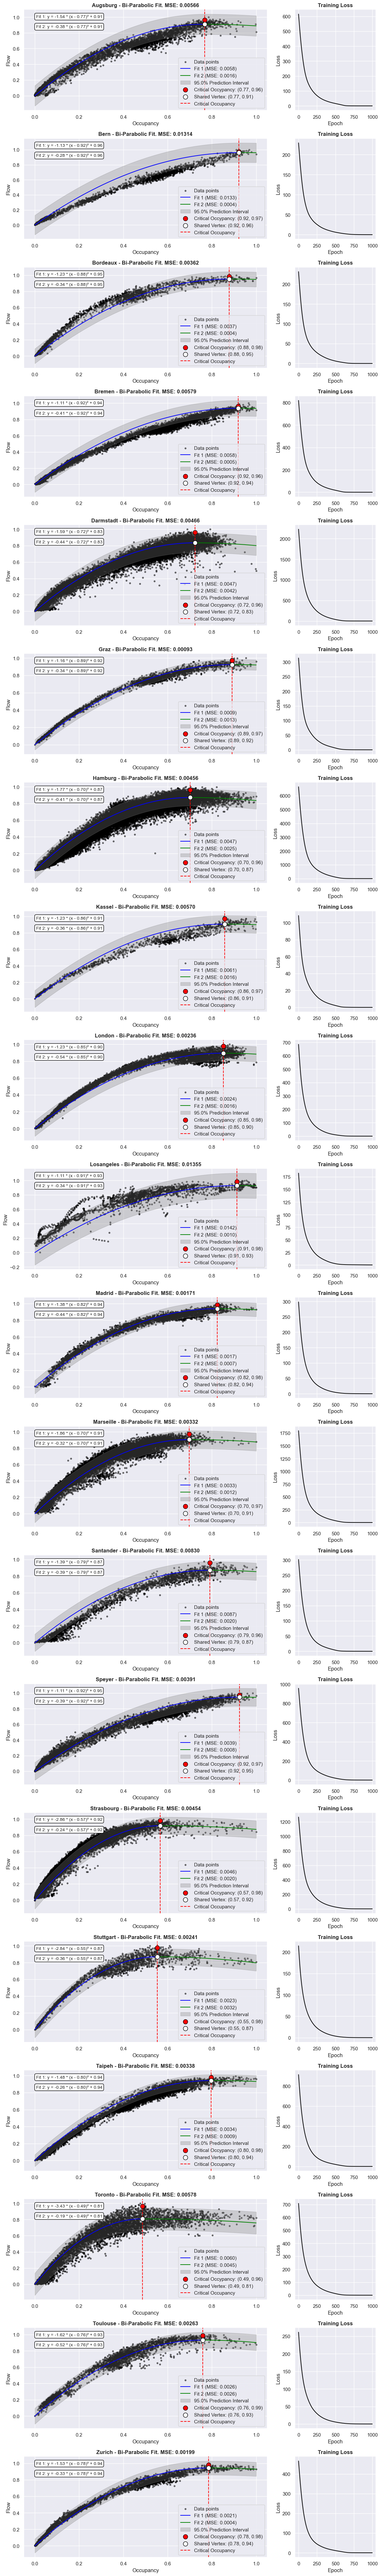

In [8]:
# Create a plot with the 20 cities used in meta-learning

cities = ['Augsburg', 'Bern', 'Bordeaux', 'Bremen', 'Darmstadt', 'Graz', 'Hamburg', 'Kassel', 'London', 'Losangeles', 'Madrid', 'Marseille', 'Santander', 'Speyer', 'Strasbourg', 'Stuttgart', 'Taipeh', 'Toronto', 'Toulouse', 'Zurich']
# un-capitalize the city names
cities = [city.lower() for city in cities]

results_df = plot_city_results_for_batch(cities, data_avg, num_epochs=1000, epoch_interval=100, alpha=1.0, beta=0.10, learning_rate=0.01, device=device, batch_size=20)

Epoch 100/1000, Loss: 409.6801, MSE fit1: 0.0077, MSE fit2: 0.0021, Flow at cd: 0.6822, Flow at junction: 0.8308
Epoch 200/1000, Loss: 187.9187, MSE fit1: 0.0062, MSE fit2: 0.0006, Flow at cd: 0.7663, Flow at junction: 0.8741
Epoch 300/1000, Loss: 98.6418, MSE fit1: 0.0046, MSE fit2: 0.0003, Flow at cd: 0.8165, Flow at junction: 0.8946
Epoch 400/1000, Loss: 52.0676, MSE fit1: 0.0038, MSE fit2: 0.0002, Flow at cd: 0.8527, Flow at junction: 0.9082
Epoch 500/1000, Loss: 25.4094, MSE fit1: 0.0033, MSE fit2: 0.0001, Flow at cd: 0.8826, Flow at junction: 0.9153
Epoch 600/1000, Loss: 8.8362, MSE fit1: 0.0033, MSE fit2: 0.0001, Flow at cd: 0.9141, Flow at junction: 0.9190
Epoch 700/1000, Loss: 1.4660, MSE fit1: 0.0038, MSE fit2: 0.0001, Flow at cd: 0.9484, Flow at junction: 0.9202
Epoch 800/1000, Loss: 0.3683, MSE fit1: 0.0042, MSE fit2: 0.0001, Flow at cd: 0.9664, Flow at junction: 0.9183
Epoch 900/1000, Loss: 0.1716, MSE fit1: 0.0044, MSE fit2: 0.0000, Flow at cd: 0.9743, Flow at junction: 0

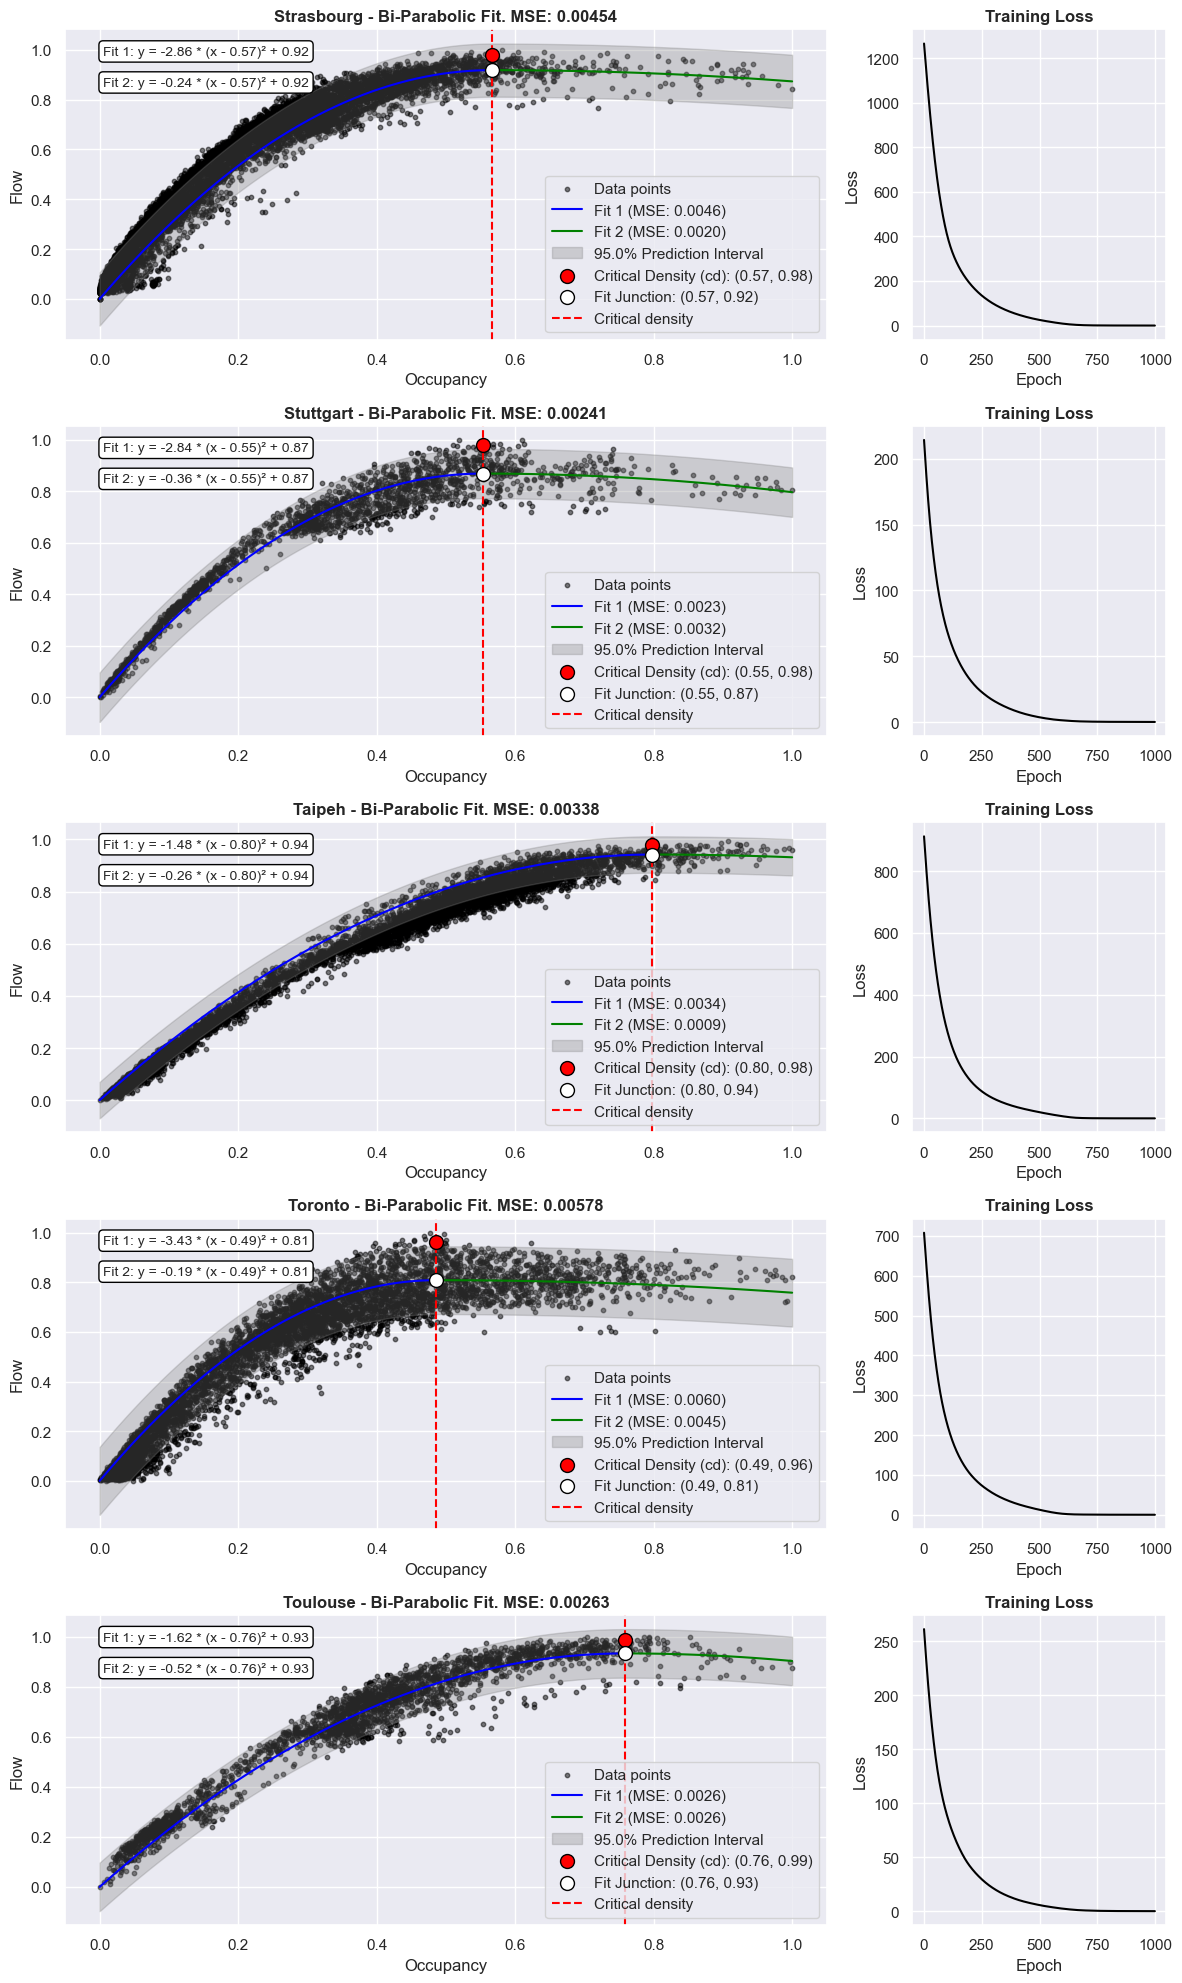

In [9]:
# run the model for 28/29 cities (bc of plot dimensions) and save the results to a csv file
cities_28 = cities[21:26]
results_df = plot_city_results_for_batch(cities_28, data_avg, num_epochs=1000, epoch_interval=100, alpha=1.0, beta=0.10, learning_rate=0.01, device=device, batch_size=5)

# save the results to a CSV file
# results_df.to_csv('28_cities_fit_params.csv', index=False)

In [ ]:
# run the model for 28/29 cities (bc of plot dimensions) and save the results to a csv file
last_9_cities = cities[25:29]
results_df = plot_city_results_for_batch(last_9_cities, data_avg, num_epochs=1000, epoch_interval=100, alpha=1.0, beta=0.10, learning_rate=0.01, device=device, batch_size=4)

# # save the results to a CSV file
# results_df.to_csv('last_9_cities_fit_params.csv', index=False)